---
# **On Deep Learning Based Chanel Decoding**
---



> * Paper title: "On Deep Learning-Based Channel Decoding"
> * Paper URL: http://arxiv.org/abs/1701.07738
> * Results are generated using Google Colaboratory.
> * Main focus on Polar Codes.
> * Colab Link to instantly start running this code: https://colab.research.google.com/drive/1Ic8PGk17ZYAIIXhGRKjPs-UWHTQxYWjj



*Install polar code package using pip*

In [0]:
!pip install py-polar-codes

*Import Required packages*

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from polarcodes import *

### **Utilities**

In [0]:
def generate_input_data(k):
    X = []
    for i in range(2**k):
        bin_str = bin(i)[2:].zfill(k)
        x = []
        for j in range(k):
            x.append(int(bin_str[j]))
        X.append(x)
    return np.array(X)

def get_index_set(N, k, snr_db):
	snr = 10**(snr_db/10)
	bhattacharya_param = np.exp(-snr)

	leaves = np.zeros(N)
	leaves[0] = bhattacharya_param

	for level in range(1, int(np.log2(N))+1):
		for i in range(0, int( (2**level)/2 )):
			p = leaves[i]
			leaves[i] = 2*p - p**2
			leaves[i + int( (2**level)/2 )] = p**2
	J = np.argsort(leaves)[:k]
	I = []
	for j in J:
		bin_str = bin(j)[2:].zfill(int(np.log2(N)))
		bin_str = bin_str[::-1]
		bin_str = '0b' + bin_str
		I.append(int(bin_str,2))
	return sorted(I)

def _polar_encode(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

def polar_encode(input, N, k, snr_db):
    indices = get_index_set(N, k ,snr_db)
    X = np.zeros((len(input), N),dtype=bool)
    X[:, indices] = input
    encoded = []

    for u in X:
        encoded.append(_polar_encode(u))
    return encoded

def BER_MAP_PolarCode(snr_db, val_size, N, k):
    
    flips = 0.0
    total_bits = 0.0
    for _ in range(10):

        u_messages = np.random.randint(0, 2, size=(val_size, k))
        for u in u_messages:
            polar_code = PolarCode(N, k)
            polar_code.construction_type = 'bb'
            Construct(polar_code, snr_db)

            polar_code.set_message(u)
            
            Encode(polar_code)
            AWGN(polar_code, snr_db)
            Decode(polar_code)

            flips += np.sum(np.abs(u-polar_code.message_received))
        total_bits += val_size*k
    
    return flips/(total_bits)

## **Neural Network Decoder**

* Input to the NND are the encoded messages.
* Custom layers are included in the NND itself to perform BPSK modulation and adding of AWGN.
* Output of NND are the probabilites that the decoded bits are 0 or 1.

In [0]:
class NND(tf.keras.Model):

    def __init__(self, k, N, hidden_layers, loss_object, optimizer, train_loss, llr_input = False):
        super(NND, self).__init__()

        self.k = k
        self.N = N
        self.llr_input = llr_input

        self.hidden_layer_1 = Dense(hidden_layers[0], input_shape = (self.N, ), activation = 'relu', name = "Hidden_Layer_1")
        self.hidden_layer_2 = Dense(hidden_layers[1], activation = 'relu', name = "Hidden_Layer_2")
        self.hidden_layer_3 = Dense(hidden_layers[2], activation = 'relu', name = "Hidden_Layer_3")

        self.output_layer = Dense(self.k, activation='sigmoid', name = "Output_Layer")

        self.loss_object = loss_object
        self.optimizer = optimizer
        self.train_loss = train_loss

    def bpsk_modulation(self, x):
        return -2*x + 1
    
    def awgn_noise(self, x, noise_var):
        return x + K.random_normal(K.shape(x), mean = 0.0, stddev = np.sqrt(noise_var))
    
    def llr(self, x, noise_var):
        return 2*x/noise_var

    def decoder(self, x, snr_db):

        noise_var = 1.0/(2* 10**( (snr_db + 10*np.log10(self.k/self.N) )/10.0) )
        
        x = self.bpsk_modulation(x)
        x = self.awgn_noise(x, noise_var)

        if self.llr_input is True:
            x = self.llr(x, noise_var)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        return self.output_layer(x)
        
    def BER(self, y_true, y_pred):
        return K.mean(K.not_equal(y_true, K.round(y_pred)))
    
    @tf.function
    def train_step(self, x, u, snr_db):
        with tf.GradientTape() as tape:
            predictions = self.decoder(x, snr_db)
            loss = self.loss_object(u, predictions)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
    
    @tf.function
    def NVE(self, S, val_size, val_snr_db_range, BER_MAP_list):
        snr_db_range = np.linspace(val_snr_db_range[0], val_snr_db_range[1], S)
        BER_NND_list = []

        for snr_db in snr_db_range:
            u_messages = np.array(np.random.randint(0, 2, size = (val_size, self.k)), dtype = np.float32)
            encoded_messages = np.array(polar_encode(u_messages, self.N, self.k, snr_db), dtype = np.float32)

            pred_messages = self.decoder(encoded_messages, snr_db)
            BER_NND_list.append(self.BER(u_messages, pred_messages))

        nve = 0
        for i in range(S):
            nve += BER_NND_list[i]/BER_MAP_list[i]   
        return nve/S
    
    def fit(self, train, epochs, snr_db, batch_size):
        for epoch in range(epochs):
            for train_x, train_u in train.batch(batch_size):
                self.train_step(train_x, train_u, snr_db)

            self.train_loss.reset_states()

## **Finding Optimal SNR**

* k = 8 and N = 16. Therefore, r = 0.5 \\
* The NND is trained for $2^{16}$ epochs, over an SNR Range of (-3,6) dB, with batch size of 256. 
* NND Architecture: 128-64-32
* Input to Neural Network is the direct channel values
* Optimizer: Adam 
* Loss function: Binary Cross Entropy 
* NVE is computed over an SNR range of 0 to 5 dB, with 20,000 examples for each SNR. 



*Parameters*

In [0]:
k = 8
N = 16
train_snr_db_range = np.linspace(-3,6, 10)
batch_size = 256
num_epochs = 2**16
layers = [126, 64, 32]

S = 20
val_snr_db_range = (0, 5)
val_size = 20000

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')

*Compute BER of MAP Decoding*

In [0]:
ber_map_list = []
for snr_db in np.linspace(val_snr_db_range[0], val_snr_db_range[1], S):
    ber_map_list.append(BER_MAP_PolarCode(N=N, k=k, snr_db=snr_db, val_size=10000 ))

*Train NND at different SNR ( $\frac{E_b}{N_0}$ = -3 dB to 6 dB )*, and compute NVE for each SNR.

In [0]:
NVE_list = []

u_messages = np.array(generate_input_data(k), dtype = np.float32)

for train_snr_db in train_snr_db_range:

    x = np.array(polar_encode(u_messages, N, k, train_snr_db), np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((np.array(x, dtype = np.float32), np.array(u_messages, dtype = np.float32)))

    tf.keras.backend.clear_session()
    model = NND(k = k, N = N, hidden_layers = layers, loss_object = loss_object,
                        optimizer = optimizer, train_loss = train_loss)
    model.fit(dataset, num_epochs, train_snr_db, batch_size)

    NVE_list.append(model.NVE(S, val_size, val_snr_db_range, ber_map_list))

*Plot NVE vs. $\frac{E_b}{N_0}$ (dB)*

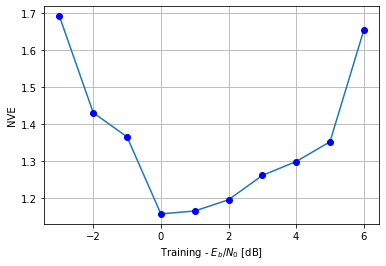

In [0]:
plt.close()
plt.xlabel("Training - $E_{b}$/$N_{0}$ [dB]")
plt.ylabel("NVE")
plt.grid()
plt.plot(np.linspace(-3,6,10), NVE_list)
plt.plot(np.linspace(-3,6,10), NVE_list, 'bo')
plt.savefig("nve.png")

### **Observations**
The NND performance is near optimal when trained around 0 - 1 dB. \\
Therefore, from here on for further investigations, it is assumed that the NND is trained at 1 dB.

## **Finding Optimal no. of Training Epochs**



*   K = 8 and N = 16. Therefore r = 0.5 
* NND Architecture: 128-64-32
* Input to Neural Network is the direct channel values.
*   NND is trained for different no. of epochs ($2^{10}, 2^{14}, 2^{16}, 2^{18}$) and BERs are plotted along with BER of MAP decoding 
*  Training SNR is 1 dB. 
* Optimizer: Adam 
* Loss function: Binary Cross Entropy 
* Batch Size = 256 
* For BER Simulation, a total of 1,000,000 examples are considered



In [0]:
ber_epochs_list = []
epochs_range = [10**12, 10, 10**12, 10**14, 10**16, 10**18]

u_messages = np.array(generate_input_data(k), dtype = np.float32)
x = np.array(polar_encode(u_messages, N, k, 1), np.float32)
dataset = tf.data.Dataset.from_tensor_slices((np.array(x, dtype = np.float32), np.array(u_messages, dtype = np.float32)))

for epochs in epochs_range:
    
    tf.keras.backend.clear_session()
    model = NND(k = k, N = N, hidden_layers = layers, loss_object = loss_object,
                        optimizer = optimizer, train_loss = train_loss)
    model.fit(dataset, epochs, 1, batch_size)

    ber_list = []
    for snr in np.linspace(0,10, 20):
        test_u = np.array(np.random.randint(0, 2, size = (1000000, k)), dtype = np.float32)
        test_x = np.array(polar_encode(test_u, N, k, snr), np.float32)

        preds = model.decoder(test_x, snr)

        ber_list.append(model.BER(test_u, preds))
    ber_epochs_list.append(ber_list)

In [0]:
ber_map_list = []
for snr_db in np.linspace(0, 8, 16):
    ber_map_list.append(BER_MAP_PolarCode(N=N, k=k, snr_db=snr_db, val_size=10000 ))

*Plotting*

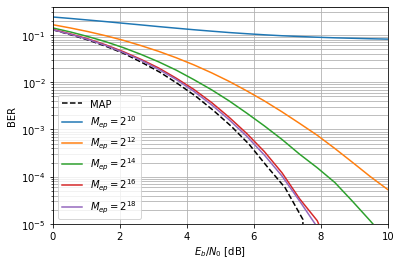

In [0]:
plt.close()
plt.yscale('log')
plt.xlabel('$E_b/N_0$ [dB]')
plt.ylabel('BER')
plt.grid(True, which="both")
plt.ylim(1e-5, 0.4)
plt.xlim(0,10)
plt.plot(np.linspace(0,8,16), ber_map_list, "black", linestyle = 'dashed')
plt.plot(np.linspace(0,10,20),ber_epochs_list[0])
plt.plot(np.linspace(0,10,20),ber_epochs_list[1])
plt.plot(np.linspace(0,10,20),ber_epochs_list[2])
plt.plot(np.linspace(0,10,20),ber_epochs_list[3])
plt.plot(np.linspace(0,10,20),ber_epochs_list[4])
plt.legend(["MAP", "$M_{ep} = 2^{10}$", "$M_{ep} = 2^{12}$", "$M_{ep} = 2^{14}$", "$M_{ep} = 2^{16}$", "$M_{ep} = 2^{18}$" ])

### **Observations** 
We can deduce from the above plot that, close to MAP performance can be achieved with NND (128-64-32) trained for $\geq 2^{16}$  epochs.

## ***Training at Mixed SNR values.**

* Now instead of training the NND with input data generaed at one particular SNR value, lets train the NND with starting at a high training SNR
and then gradually reducing it.
* A range of SNR values, -3 to 6 dB (10 different SNRs) is considered for training. starting with 6 dB.
* Train the NND in this manner for three training epochs. ( $2^{10}, 2^{12}, 2^{14}$ )
* For BER simulations, 1,000,000 codewords per SNR point are considered.

In [0]:
u_messages = np.array(generate_input_data(k), dtype = np.float32)

ber_list_all_snr = []

for num_epochs in [2**10, 2**12, 2**14]:

    tf.keras.backend.clear_session()
    loss_object = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.Adam()
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    model = NND(k = 8, N = 16, hidden_layers = [128, 64, 32], loss_object = loss_object,
                        optimizer = optimizer, train_loss = train_loss)

    for train_snr_db in reversed(np.linspace(-3,6,10)):

        x = np.array(polar_encode(u_messages, N, k, train_snr_db), np.float32)
        dataset = tf.data.Dataset.from_tensor_slices((np.array(x, dtype = np.float32), np.array(u_messages, dtype = np.float32)))

        model.fit(dataset, num_epochs, train_snr_db, 256)

        ber_list = []
        for snr in np.linspace(0,10, 20):
            test_u = np.array(np.random.randint(0, 2, size = (1000000, 8)), dtype = np.float32)
            test_x = np.array(polar_encode(test_u, 16, 8, snr), np.float32)

            preds = model.decoder(test_x, snr)
            ber_list.append(model.BER(test_u, preds))
    ber_list_all_snr.append(ber_list)

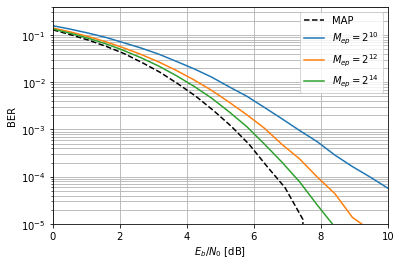

In [18]:
ber_map_list = [0.1286525, 0.10107375, 0.077645, 0.05711125, 0.04022625, 0.0259875, 0.01623125, 0.0092775, 0.0050575, 0.0025075, 0.00115875, 0.00048, 0.00016375, 5.875e-05, 1.25e-05, 0.0]
plt.close()
plt.yscale('log')
plt.xlabel('$E_b/N_0$ [dB]')
plt.ylabel('BER')
plt.grid(True, which="both")
plt.ylim(1e-5, 0.4)
plt.xlim(0,10)
plt.plot(np.linspace(0,8,16), ber_map_list, "black", linestyle = 'dashed')
plt.plot(np.linspace(0,10,20), ber_list_all_snr[0])
plt.plot(np.linspace(0,10,20), ber_list_all_snr[1])
plt.plot(np.linspace(0,10,20), ber_list_all_snr[2])
plt.legend(["MAP", "$M_{ep} = 2^{10}$", "$M_{ep} = 2^{12}$", "$M_{ep} = 2^{14}$"])

### **Observations**
* Comparing the above plot with BER plot from previous section, it can be observed that training the NND with mixed SNR values gives better performance compared to training with only one SNR value ( if both trained for same number of epochs)
* Close to MAP performance is obtained by training for $2^{14}$ epochs, when the NND is trained with mixed SNR values.
* Whereas, when the NND is trained with only one SNR ( 1 dB), close to MAP performance is achieved by training for $2^{16}$ epochs.

## **Finding Optimal NND Architecture**

* k = 8, N = 16.
* The NND is trained for differnet sizes
    * 128-64-32
    * 256-128-64
    * 512-256-128
    * 1024-512-256
* For each NND architecture, it is trained for 3 different num of training epochs $2^{12}, 2^{14}, 2^{16}$
* Loss function: Binary Cross Entropy
* Oprimizer: Adam
* Training SNR: 1 dB
* NVE is calculated for 10 differnt SNRs over a range of 0 to 5 dB with 10,000 examples for each SNR.


In [0]:
layers1 = [128, 64, 32]
layers2 = [256, 128, 64]
layers3 = [512, 256, 128]
layers4 = [1024, 512, 256]
all_layers = [layers1, layers2, layers3, layers4]

*Compute BER of MAP decoding (used to compute NVE)*

In [0]:
ber_map_list = []
for snr_db in np.linspace(0, 5, 10):
    ber_map_list.append(BER_MAP_PolarCode(N=N, k=k, snr_db=snr_db, val_size=10000))

*Training*

In [0]:
u_messages = np.array(generate_input_data(k), dtype = np.float32)
x = np.array(polar_encode(u_messages, N, k, 1), np.float32)
dataset = tf.data.Dataset.from_tensor_slices((np.array(x, dtype = np.float32), np.array(u_messages, dtype = np.float32)))

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')

nve_layers = []

for layers in all_layers:

    nve_layer = []
    for num_epochs in [2**12, 2**14, 2**16]:

        tf.keras.backend.clear_session()
        model = NND(k = k, N = N, hidden_layers = layers, loss_object = loss_object,
                            optimizer = optimizer, train_loss = train_loss)
        
        model.fit(dataset, num_epochs, 1, batch_size)
        nve_layer.append(model.NVE(10, 10000, val_snr_db_range, ber_map_list))
    
    nve_layers.append(nve_layer)
    print(nve_layers[-1])

*Plotting NVE for different NND Architectures trained for a range of training epochs.*

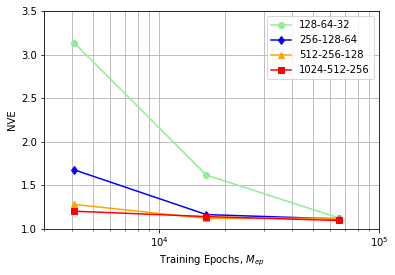

In [71]:
plt.close()
plt.xscale("log")
plt.grid(True, which="both")
plt.ylim(1, 3.5)
plt.xlim(3e3, 1e5)
plt.xlabel("Training Epochs, $M_{ep}$")
plt.ylabel("NVE")

plt.plot([2**12, 2**14, 2**16], nve_layers[0], "lightgreen", marker = "o")
plt.plot([2**12, 2**14, 2**16], nve_layers[1], "blue", marker = "d")
plt.plot([2**12, 2**14, 2**16], nve_layers[2], "orange", marker = "^")
plt.plot([2**12, 2**14, 2**16], nve_layers[3], "red", marker = "s")
plt.legend(["128-64-32", "256-128-64", "512-256-128", "1024-512-256"])

### **Observations**
* It can be deduced from the above plot that, with increasing the size of NND
close to MAP performance ( NVE ~ 1) is achieved for less number of training.

## **Capability of Generalization**

* Here, the NND is trained on a subset, that is covers only p% of the entire set of valid codewords. 
* p = 70%, 80%, 90%, 100%. 
* And tested on the
    * whole set of valid codewords ( $\chi$ )
    * codewords which are unseen by the NND during training ( $\overline{\chi_{p}}$ )

* k = 8, N = 16. Therefore r = 0.5
* 128-64-32
* Training SNR = 1 dB
* Optimizer: Adam
* Loss function: Binary Cross Entropy
* Trained for $2^{16}$ Epochs.

In [0]:
P = [0.7, 0.8, 0.9, 1]

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')

u_messages = np.array(generate_input_data(k), dtype = np.float32)
BERs_seen, BERs_unseen = [], []

for p in P:
    
    np.random.shuffle(u_messages)
    seen_input = np.array( u_messages[:int(len(u_messages)*p)], dtype = np.float32)
    unseen_input = np.array( u_messages[int(len(u_messages)*p):], dtype = np.float32)
    
    x = np.array(polar_encode(seen_input, N, k, 1), np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((np.array(x, dtype = np.float32), np.array(seen_input, dtype = np.float32)))

    tf.keras.backend.clear_session()
    model = NND(k = k, N = N, hidden_layers = [128, 64, 32], loss_object = loss_object,
                        optimizer = optimizer, train_loss = train_loss)
    
    model.fit(dataset, 2**16, 1, 256)

    bers_seen, bers_unseen = [], []

    for snr_db in np.linspace(0,10,20):
        
        encoded_messages = np.array(polar_encode(u_messages, N, k, snr_db) , dtype = np.float32)
        test_u1, test_x1 = u_messages, encoded_messages
        for _ in range(200):
            test_u1 = np.append(test_u1, u_messages, axis = 0)
            test_x1 = np.append(test_x1, encoded_messages, axis = 0)
        preds1 = model.decoder(test_x1, snr_db)
        flips = np.array( np.where(  np.sum(np.abs( np.round(preds1) - test_u1), axis = 1) > 0 ) )
        bers_seen.append(flips.size/len(preds1))

        if p  != 1:
            x2 = np.array(polar_encode(unseen_input, N, k, snr_db), np.float32)
            test_u2, test_x2 = unseen_input, x2
            for _ in range(4000):
                test_u2 = np.append(test_u2, unseen_input, axis = 0)
                test_x2 = np.append(test_x2, x2, axis = 0)
            preds2 = model.decoder(test_x2, snr_db)
            flips = np.array( np.where(  np.sum(np.abs( np.round(preds2) - test_u2), axis = 1) > 0 ) )
            bers_unseen.append(flips.size/len(preds2))

    BERs_seen.append(bers_seen)
    BERs_unseen.append(bers_unseen)

*Plot Block Error Rates for 128-64-32 NND.* \\
*Solid and dashed lines show performance on $\overline{\chi_{p}}$ and $\chi$*

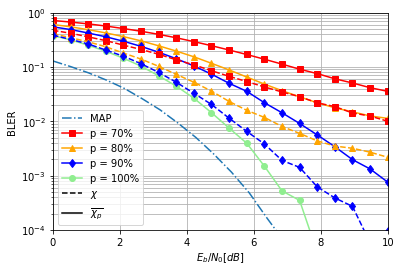

In [73]:
plt.close()
plt.yscale("log")
plt.grid(True, which="both")
plt.ylim(1e-4, 1)
plt.xlim(0,10)

ber_map = [0.1286525, 0.10107375, 0.077645, 0.05711125, 0.04022625, 0.0259875, 0.01623125, 0.0092775, 0.0050575, 0.0025075, 0.00115875, 0.00048, 0.00016375, 5.875e-05, 1.25e-05, 0.0]
plt.plot(np.linspace(0,8,16), ber_map, "-.", label = "MAP")

plt.plot(np.linspace(0,10,20), BERs_unseen[0], "red", marker = "s", label = "70%")
plt.plot(np.linspace(0,10,20), BERs_unseen[1], "orange", marker = "^", label = "80%")
plt.plot(np.linspace(0,10,20), BERs_unseen[2], "blue", marker = "d", label = "90%")
plt.plot(np.linspace(0,10,20), BERs_seen[3], "lightgreen", marker = "o")

plt.plot(0,0, "black", linestyle = "dashed")
plt.plot(0,0, "black")

plt.plot(np.linspace(0,10,20), BERs_seen[0], "red", marker = "s", linestyle='dashed')
plt.plot(np.linspace(0,10,20), BERs_seen[1], "orange", marker = "^", linestyle='dashed')
plt.plot(np.linspace(0,10,20), BERs_seen[2], "blue", marker = "d", linestyle='dashed')

plt.legend(["MAP", "p = 70%", "p = 80%", "p = 90%", "p = 100%", "$\chi$", "$\overline{\chi_{p}}$"])
plt.xlabel("$E_{b}/N_{0} [dB]$")
plt.ylabel("BLER")
plt.savefig("cog.png")

### **Observations**
* Even if the NND doesn't see the whole set of valid codewords, the NND is able to decode properly for some extent. But this generalization is vanishing for larger NNs.